# Data Wrangling

## Introduction

The present goal is to collect data from the MIMIC-IV dataset, organize it, and make sure it is well defined. Some data cleaning will be done at this stage.

### Recap of Data Science Problem

The hospital wants to identify patients with longer and shorter lengths of stay to allocate resources more effectively. Target population will be identified and actionable steps will be measured to see impact on overall length of stay.

The hospital is experiencing an unprecedented level of demand for beds. As such, they are experiencing an over-crowding issue. Presently, they would like to explore factors that influence length of stay to later explore the strategic issue that is reducing length of stay. What is currently needed is a diagnostic tool to identify the factors influencing length of stay. They want to provide exactly the care needed by an individual the moment they need it. But the moment they don’t need it, resource utilization plummets. Complaints during this transition period edge up consuming clinical attention that could be better spent elsewhere. In addition, the risks of hospital-acquired infections, falls and other adverse reactions also increase during this period. The most pressing financial issue is patient throughput. The faster you can get a patient out of their high-acuity bed and onto the next level of care, the better, as that means the next patient can take their place more quickly. Getting patients in and out of the hospital efficiently is a way to keep your revenue model churning. Having a predictive model of length of stay will help clinical staff triage more efficiently and form a consistent care process to get patients to a more appropriate acuity level quickly keeping bed turnover as high as possible. 

We wish to establish a standard measurable to predict length of stay from which to manipulate to see a decrease in length of stay. Some potential manipulations include but are not limited to: 

possible manipulations to be determined.

The scope of the solution space is limited to changes that will support shorter length of stay. Constraints include missing data regarding workflows presently in place.

In [108]:
import ipywidgets as widgets
import sys
from pathlib import Path
import os
import importlib
import pandas as pd
import matplotlib.pyplot as plt

## To predict length of stay, the admissions, patients, icustays, and diagnosis_ICD tables.

### MIMIC-IV hosp and icu data:

In [109]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/Users/alissazoltowski/Documents/Springboard/Projects/MIMIC-IV-Data-Pipeline': ['.DS_Store', 'requirements.txt', 'images', 'Untitled.ipynb', 'Data Wrangling - Predicting LOS.ipynb', 'mimic4_preprocess_util.py', 'mainPipeline.ipynb', 'utils', 'README.md', 'mimiciv', 'saved_models', 'notes', '.gitignore', 'model', '.ipynb_checkpoints', 'preprocessing', '.git', 'data', 'preprocess_outcomes.py']


#### Admissions table

The admissions table gives information regarding a patient’s admission to the hospital. Since each unique hospital visit for a patient is assigned a unique hadm_id, the admissions table can be considered as a definition table for hadm_id. Information available includes timing information for admission and discharge, demographic information, the source of the admission, and so on.<br> 

Links to:<br> patients on subject_id
<br>

**interested in the subject id (patient), hadm id (admission event), admission type, admit time and discharge time.**

In [110]:
admissions = pd.read_csv('mimiciv/2.0/hosp/admissions.csv.gz')

In [111]:
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [112]:
# Unique admission events
print('Dataset has {} number of unique admission events.'.format(admissions['hadm_id'].nunique()))

# Unique patients
print('Dataset has {} number of unique patients.'.format(admissions['subject_id'].nunique()))

Dataset has 431231 number of unique admission events.
Dataset has 180733 number of unique patients.


**This means we have quite a few repeat visitors. We should merge on admission events (hadm_id) later on to avoid analysis on the same patient encounter.**

In [113]:
admissions['hadm_id'].duplicated().any()

False

##### Number of missing values by column

In [114]:
missing = pd.concat([admissions.isnull().sum(), 100 * admissions.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
deathtime,422633,98.006173
edregtime,131949,30.598218
edouttime,131949,30.598218
discharge_location,119155,27.631362
marital_status,9233,2.141080
admit_provider_id,4,0.000928
subject_id,0,0.000000
hadm_id,0,0.000000
admittime,0,0.000000
dischtime,0,0.000000


There are missing values in death time, edregtime, edouttime, discharge loctaion, and marital status columns.

In [115]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431231 entries, 0 to 431230
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            431231 non-null  int64 
 1   hadm_id               431231 non-null  int64 
 2   admittime             431231 non-null  object
 3   dischtime             431231 non-null  object
 4   deathtime             8598 non-null    object
 5   admission_type        431231 non-null  object
 6   admit_provider_id     431227 non-null  object
 7   admission_location    431231 non-null  object
 8   discharge_location    312076 non-null  object
 9   insurance             431231 non-null  object
 10  language              431231 non-null  object
 11  marital_status        421998 non-null  object
 12  race                  431231 non-null  object
 13  edregtime             299282 non-null  object
 14  edouttime             299282 non-null  object
 15  hospital_expire_f

In [116]:
# Made admittime and dischtime datetime objects
pd.to_datetime(admissions['admittime'])
pd.to_datetime(admissions['dischtime'])

0        2180-05-07 17:15:00
1        2180-06-27 18:49:00
2        2180-08-07 17:50:00
3        2180-07-25 17:55:00
4        2160-03-04 06:26:00
                 ...        
431226   2149-01-18 17:00:00
431227   2147-08-04 18:10:00
431228   2164-09-17 13:42:00
431229   2164-07-28 12:15:00
431230   2145-11-11 12:57:00
Name: dischtime, Length: 431231, dtype: datetime64[ns]

In [117]:
# Calculate LOS
# Convert admission and discharge times to datatime type
admissions['ADMITTIME'] = pd.to_datetime(admissions['admittime'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['dischtime'])

# Calculating the Length of Stay variable using the difference between Discharge time and Admit time 
# Convert timedelta type into float 'days'. Note: There are 86400 seconds in a day
admissions['LOS'] = (admissions['DISCHTIME'] - admissions['ADMITTIME']).dt.total_seconds()/86400
admissions['LOS'].describe()

count    431231.000000
mean          4.483283
std           6.626732
min          -0.945139
25%           1.070139
50%           2.737500
75%           5.241667
max         295.988194
Name: LOS, dtype: float64

**The minimum stay time is negative, this is not possible, so we should further explore this data in EDA.**

In [118]:
# Drop rows with negative LOS. The negative LOS means that the patient was brought dead to the ICU.
admissions['LOS'][admissions['LOS'] > 0].describe()

count    431089.000000
mean          4.484862
std           6.627251
min           0.000694
25%           1.071528
50%           2.738194
75%           5.243750
max         295.988194
Name: LOS, dtype: float64

In [119]:
admissions = admissions[admissions['LOS'] > 0]

In [120]:
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,ADMITTIME,DISCHTIME,LOS
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,2180-05-06 22:23:00,2180-05-07 17:15:00,0.786111
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0,2180-06-26 18:27:00,2180-06-27 18:49:00,1.015278
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0,2180-08-05 23:44:00,2180-08-07 17:50:00,1.754167
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0,2180-07-23 12:35:00,2180-07-25 17:55:00,2.222222
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0,2160-03-03 23:16:00,2160-03-04 06:26:00,0.298611


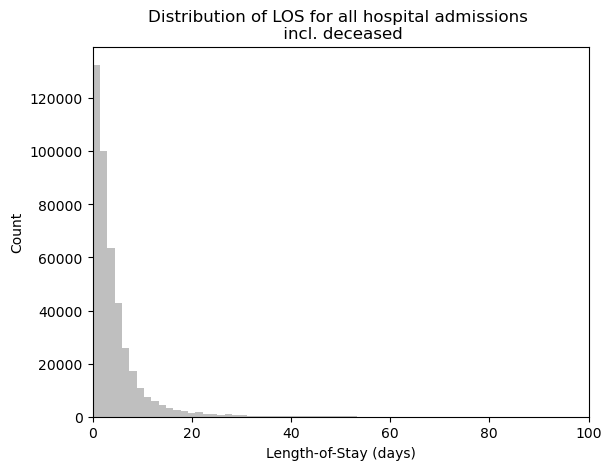

In [121]:
# Plot LOS Distribution
plt.hist(admissions['LOS'], bins=200, color = '0.75')
plt.xlim(0, 100)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [122]:
# Descriptive analysis of LOS metric (target variable)
mean_los = admissions['LOS'].mean() 
median_los = admissions['LOS'].median()
min_los = admissions['LOS'].min()
max_los = admissions['LOS'].max()

print("Mean LOS: ",mean_los)
print("Median LOS: ",median_los)
print("Min LOS: ",min_los)
print("Max LOS: ",max_los)

Mean LOS:  4.484861981323351
Median LOS:  2.738194444444445
Min LOS:  0.0006944444444444446
Max LOS:  295.98819444444445


In [123]:
# Filtering only admission with LOS less than 40 days to reduce the skewness of the data.
admissions = admissions[admissions['LOS'] <40]

In [124]:
admissions.describe()

,subject_id,hadm_id,hospital_expire_flag,LOS
count,4.287890e+05,4.287890e+05,428789.000000,428789.000000
mean,1.500779e+07,2.500340e+07,0.019278,4.189475
std,2.877525e+06,2.888415e+06,0.137499,4.931134
min,1.000003e+07,2.000002e+07,0.000000,0.000694
25%,1.251594e+07,2.250126e+07,0.000000,1.065278
50%,1.501323e+07,2.500668e+07,0.000000,2.722222
75%,1.749638e+07,2.750529e+07,0.000000,5.163889
max,1.999999e+07,2.999993e+07,1.000000,39.997917


In [125]:
admissions['admission_type'].value_counts()

EW EMER.                       148426
EU OBSERVATION                  94726
OBSERVATION ADMIT               52235
URGENT                          44138
SURGICAL SAME DAY ADMISSION     34134
DIRECT EMER.                    19315
DIRECT OBSERVATION              18699
ELECTIVE                        10490
AMBULATORY OBSERVATION           6626
Name: admission_type, dtype: int64

In [126]:
# Bar plot function
def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by df categorical series name 
    '''
    results = admissions[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();

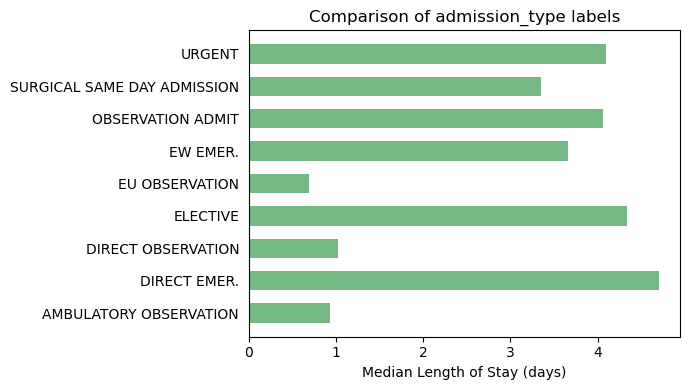

In [127]:
plot_los_groupby('admission_type')

#### Patients Table
<p> Patients' gender, age, and date of death if information exists.
Information that is consistent for the lifetime of a patient is stored in this table.

<br> </p> **interested in subject id and age**

In [128]:
patients = pd.read_csv('mimiciv/2.0/hosp/patients.csv.gz')

In [129]:
patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


In [130]:
# Unique patients
print('Dataset has {} number of unique patients.'.format(patients['subject_id'].nunique()))

Dataset has 299712 number of unique patients.


The number of entries is equal to the number of unique patients. No duplicates.

##### Number of missing values by column

In [131]:
missing = pd.concat([patients.isnull().sum(), 100 * patients.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
dod,270636,90.298687
subject_id,0,0.000000
gender,0,0.000000
anchor_age,0,0.000000
anchor_year,0,0.000000
anchor_year_group,0,0.000000


There are no missing values.

In [132]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299712 entries, 0 to 299711
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   subject_id         299712 non-null  int64 
 1   gender             299712 non-null  object
 2   anchor_age         299712 non-null  int64 
 3   anchor_year        299712 non-null  int64 
 4   anchor_year_group  299712 non-null  object
 5   dod                29076 non-null   object
dtypes: int64(3), object(3)
memory usage: 13.7+ MB


In [133]:
patients.describe()

,subject_id,anchor_age,anchor_year
count,2.997120e+05,299712.000000,299712.000000
mean,1.500885e+07,48.539888,2151.124056
std,2.885019e+06,20.895650,23.464598
min,1.000003e+07,18.000000,2110.000000
25%,1.250796e+07,29.000000,2131.000000
50%,1.501416e+07,48.000000,2151.000000
75%,1.750489e+07,65.000000,2171.000000
max,1.999999e+07,91.000000,2208.000000


#### ICU stays
Defines each ICU stay in the database using STAY_ID.
<br> **interested in the in and out times, and subject id, hadm_id to merge on.**

In [134]:
icustays = pd.read_csv('mimiciv/2.0/icu/icustays.csv.gz')

In [135]:
icustays.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588


In [136]:
# Unique admission events
print('Dataset has {} number of unique admission events.'.format(icustays['hadm_id'].nunique()))

# Unique patients
print('Dataset has {} number of unique patients.'.format(icustays['subject_id'].nunique()))

Dataset has 66239 number of unique admission events.
Dataset has 50920 number of unique patients.


In [137]:
icustays['hadm_id'].duplicated().any()

True

In [138]:
icustays['stay_id'].duplicated().any()

False

**Repeat visitors noted. There are also duplicated admission events as patients are often transferred within the same day denoting a new admision event for the same stay. We will have to encorporate the stay_id to merge with other dataframes.**

##### Number of missing values by column

In [139]:
missing = pd.concat([icustays.isnull().sum(), 100 * icustays.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
subject_id,0,0.0
hadm_id,0,0.0
stay_id,0,0.0
first_careunit,0,0.0
last_careunit,0,0.0
intime,0,0.0
outtime,0,0.0
los,0,0.0


There are no missing values.

In [140]:
icustays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73181 entries, 0 to 73180
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      73181 non-null  int64  
 1   hadm_id         73181 non-null  int64  
 2   stay_id         73181 non-null  int64  
 3   first_careunit  73181 non-null  object 
 4   last_careunit   73181 non-null  object 
 5   intime          73181 non-null  object 
 6   outtime         73181 non-null  object 
 7   los             73181 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 4.5+ MB


In [141]:
icustays.describe()

,subject_id,hadm_id,stay_id,los
count,7.318100e+04,7.318100e+04,7.318100e+04,73181.000000
mean,1.499819e+07,2.498133e+07,3.499274e+07,3.451931
std,2.886067e+06,2.884400e+06,2.889261e+06,4.922840
min,1.000003e+07,2.000009e+07,3.000015e+07,0.001250
25%,1.249126e+07,2.248335e+07,3.248935e+07,1.084225
50%,1.499894e+07,2.496964e+07,3.499389e+07,1.926782
75%,1.751327e+07,2.747180e+07,3.748840e+07,3.713322
max,1.999999e+07,2.999983e+07,3.999981e+07,110.232280


___________________________________________________________________________

In [142]:
icustays.keys()

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los'],
      dtype='object')

FIRST_CAREUNIT and LAST_CAREUNIT contain, respectively, the first and last ICU type in which the patient was cared for. As an stay_id groups all ICU admissions within 24 hours of each other, it is possible for a patient to be transferred from one type of ICU to another and have the same stay_id.

In [143]:
icustays['first_careunit'].unique()

array(['Medical Intensive Care Unit (MICU)',
       'Surgical Intensive Care Unit (SICU)',
       'Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'Cardiac Vascular Intensive Care Unit (CVICU)',
       'Coronary Care Unit (CCU)', 'Neuro Intermediate',
       'Trauma SICU (TSICU)', 'Neuro Stepdown',
       'Neuro Surgical Intensive Care Unit (Neuro SICU)'], dtype=object)

In [144]:
# Converting different categories of first care unit into ICU and NICU groups
icustays['first_careunit'].replace({'Coronary Care Unit (CCU)': 'ICU',
                                  'Neuro Stepdown': 'NICU',
                                  'Neuro Intermediate': 'NICU',
                                  'Cardiac Vascular Intensive Care Unit (CVICU)': "ICU",
                                  'Neuro Surgical Intensive Care Unit (Neuro SICU)': 'ICU',
                                  'Medical/Surgical Intensive Care Unit (MICU/SICU)': 'ICU',
                                  'Medical Intensive Care Unit (MICU)': 'ICU',
                                  'Surgical Intensive Care Unit (SICU)': 'ICU',
                                  'Trauma SICU (TSICU)': 'ICU'}, inplace=True)

In [145]:
icustays['cat'] = icustays['first_careunit']
icu_list = icustays.groupby('hadm_id')['cat'].apply(list).reset_index()

icustays['first_careunit'].value_counts()

ICU     70139
NICU     3042
Name: first_careunit, dtype: int64

#### Diagnosis ICD table
Billed ICD-9/ICD-10 diagnoses for hospitalizations.
diagnoses_icd

During routine hospital care, patients are billed by the hospital for diagnoses associated with their hospital stay. This table contains a record of all diagnoses a patient was billed for during their hospital stay using the ICD-9 and ICD-10 ontologies. Diagnoses are billed on hospital discharge, and are determined by trained persons who read signed clinical notes.

In [146]:
# Diagnosis for each admission to the hospi
diagnoses_icd = pd.read_csv('mimiciv/2.0/hosp/diagnoses_icd.csv.gz')

In [147]:
diagnoses_icd.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [148]:
# Unique admission events
print('Dataset has {} number of unique admission events.'.format(diagnoses_icd['hadm_id'].nunique()))

# Unique patients
print('Dataset has {} number of unique patients.'.format(diagnoses_icd['subject_id'].nunique()))

Dataset has 430852 number of unique admission events.
Dataset has 180640 number of unique patients.


In [149]:
diagnoses_icd['hadm_id'].duplicated().any()

True

In [150]:
diagnoses_icd['subject_id'].duplicated().any()

True

There will be, at times, multiple diagnoses for one patient. 

##### Number of missing values by column

In [151]:
missing = pd.concat([diagnoses_icd.isnull().sum(), 100 * diagnoses_icd.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
subject_id,0,0.0
hadm_id,0,0.0
seq_num,0,0.0
icd_code,0,0.0
icd_version,0,0.0


There are no missing values.

In [152]:
diagnoses_icd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  int64 
dtypes: int64(4), object(1)
memory usage: 181.4+ MB


This table should be recoded on a categorical basis to help in predicting lenght of stay. This will be done later.